# **PRISM ALGORITHM**

# Installation

The main page for PRISM rules is from https://towardsdatascience.com/prism-rules-in-python-14d2cfd801a3/

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


In [ ]:
# Load the Wine Dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)

# Display the first 5 rows
df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [ ]:
# Display dataset information
df.info()
# Display statistical summary
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [ ]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


In [ ]:
# Check for missing values
df.isnull().sum()


alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
Y                               0
dtype: int64

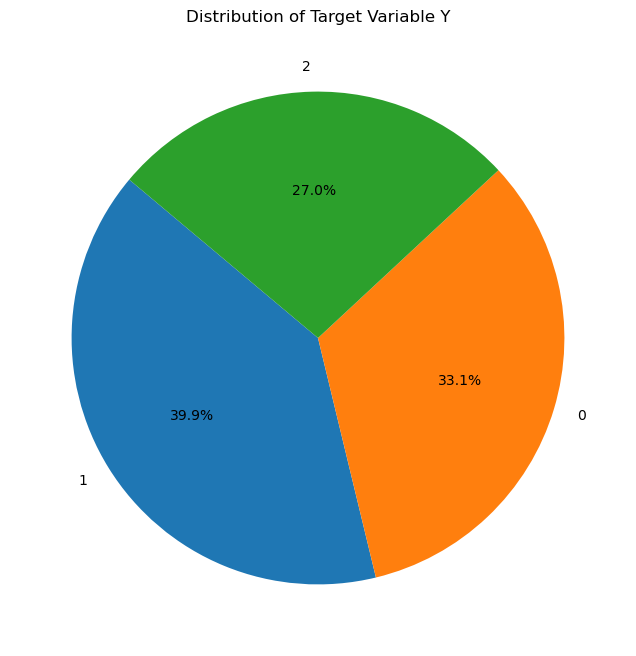

In [ ]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

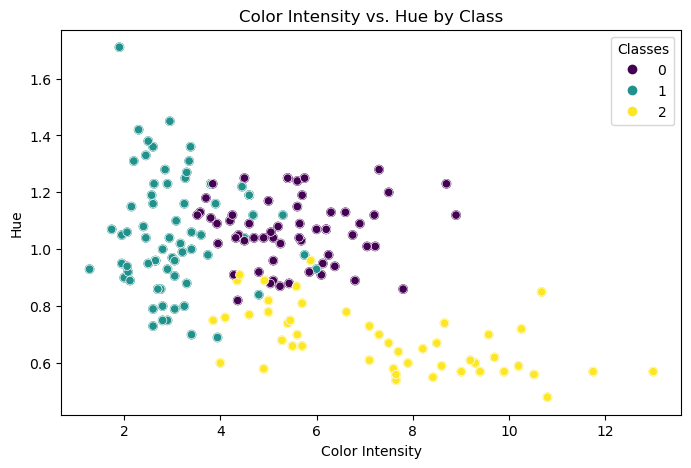

In [ ]:
plt.figure(figsize=(8,5))
scatter = plt.scatter(df['color_intensity'], df['hue'], c=df['Y'], cmap='viridis')
sns.scatterplot(x='color_intensity', y='hue', hue='Y', data=df, palette='viridis')
plt.title('Color Intensity vs. Hue by Class')
plt.xlabel('Color Intensity')
plt.ylabel('Hue')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


We can see visible clusters of wine classes based on color intensity and hue.
Class 0 wines tend to have higher color intensity and hue, while class 2 wines are generally lighter.

# Generate Rules with PRISM

In [45]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(100), 'Y')


........................................................................
Target: 0
........................................................................
proline = High AND flavanoids = High
   Support:  the target has value: '0' for 100.000% of the 27 rows matching the rule 
   Coverage: the rule matches: 27 out of 32 rows for target value: '0'. This is:
      84.375% of total rows for target value: '0'
      27.000% of total rows in data

........................................................................
Target: 1
........................................................................
alcohol = Low AND color_intensity = Low
   Support:  the target has value: '1' for 100.000% of the 26 rows matching the rule 
   Coverage: the rule matches: 26 out of 42 rows for target value: '1'. This is:
      61.905% of total rows for target value: '1'
      26.000% of total rows in data

........................................................................
Target: 2
...................

Each rule represents a pattern describing a wine class.
For example:

“If alcohol = High and color_intensity = High → Class 0”
means wines with strong alcohol and deep color tend to belong to class 0.

# Bin Ranges Result

In [46]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.03,12.43,54
1,alcohol,1,12.43,13.48,63
2,alcohol,2,13.48,14.39,59
3,malic_acid,0,0.74,1.67,56
4,malic_acid,1,1.67,2.39,56
5,malic_acid,2,2.39,5.51,64
6,ash,0,1.36,2.28,59
7,ash,1,2.28,2.51,67
8,ash,2,2.51,3.23,52
9,alcalinity_of_ash,0,10.60,18.00,53


# Test on Y Pred

In [47]:
# we use the rest of our data for testing, in this case is 50 rows
y_pred = prism.predict(df.tail(50).drop(columns=['Y']))
f1_score(df.tail(50)['Y'], y_pred, average=None)

array([0.77419355, 0.79069767, 0.92307692])

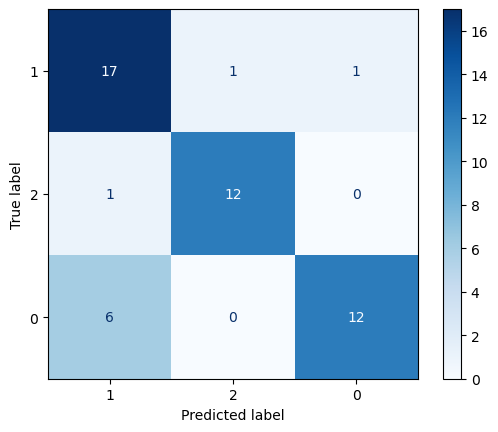

In [48]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(50)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [49]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(50)['Y'], y_pred))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77        18
           1       0.71      0.89      0.79        19
           2       0.92      0.92      0.92        13

    accuracy                           0.82        50
   macro avg       0.85      0.83      0.83        50
weighted avg       0.84      0.82      0.82        50



The confusion matrix shows how many samples were correctly classified for each wine type.

The classification report summarizes precision, recall, and F1-score.

The class with the highest F1-score is predicted best.

Misclassifications may occur when feature values overlap between classes.

In [50]:
# Create new data points for the Iris dataset
# You can change these values to test different scenarios
new_wine_data = {
    'alcohol': [14.0, 14.00],
    'malic_acid': [2.0, 2.0],
    'ash': [2.3, 2.2],
    'alcalinity_of_ash': [19.0, 11.0],
    'magnesium': [95.0, 95.0],
    'total_phenols': [2.2, 2.5],
    'flavanoids': [0.14, 0.5],
    'nonflavanoid_phenols': [0.14, 0.5],
    'proanthocyanins': [1.6, 1.5],
    'color_intensity': [7.0, 6.0],
    'hue': [0.7, 0.6],
    'od280/od315_of_diluted_wines': [3.2, 3.0],
    'proline': [550.0, 1400.0]
    }

new_wine_df = pd.DataFrame(new_wine_data)

# Predict on the new Iris data using the prism model trained on Iris data
wine_prediction = prism.predict(new_wine_df)
# Assign predictions to a new column in the DataFrame
new_wine_df['Predicted Class'] = wine_prediction

# Display the new data and prediction
print("New Iris Data Points:")
display(new_wine_df)

New Iris Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,2


The PRISM model applies the same learned rules to the new samples.

Example interpretation (you’ll adjust based on your rule output):

Sample 1: High alcohol and color intensity match Class 0’s rule → predicted as Class 0.

Sample 2: Higher proline and phenol content match Class 1’s rule → predicted as Class 1.